In [1]:
# Load python modules
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Resizing, Rescaling
import seaborn as sn
import tensorflow_datasets as tfds
from sklearn.utils import shuffle 
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
from tqdm import tqdm  # Perform iterature with progress bar
import numpy as np
import cv2
import os

In [2]:
#Class labelsb
class_names = ['Glass', 'Metal', 'Paper', 'Textile']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)
IMAGE_SIZE = (64, 64)

In [3]:
print('Number of classes:', nb_classes)

Number of classes: 4


In [4]:
resize_layer_32 = tf.keras.Sequential([
    Resizing(32, 32),
])

In [5]:
def load_data():
    """
        Load the data from local folder
        
    """
    datasets = ['C:/Mani/Dataset/dataset1/train_ds',
               'C:/Mani/Dataset/dataset1/test_ds']
    
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [6]:
#Prepare dataset for training and testing
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading C:/Mani/Dataset/dataset1/train_ds


100%|███████████████████████████████████████████████████████████████████████████████| 270/270 [00:01<00:00, 206.29it/s]


Loading C:/Mani/Dataset/dataset1/test_ds


100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 187.24it/s]


In [7]:
#Check the training and testing image shape
train_images.shape, test_images.shape

((1080, 64, 64, 3), (200, 64, 64, 3))

In [8]:
# Shuffle only the training dataset
np.random.seed(321)
train_images, train_labels = shuffle(train_images, train_labels)

In [9]:
#Check the number of training dataset
print('No of training images:', train_images.shape[0])

No of training images: 1080


In [10]:
#Normalise train and test image dataset from 0,255 to 0,1
train_images = train_images / 255.0 
test_images = test_images / 255.0

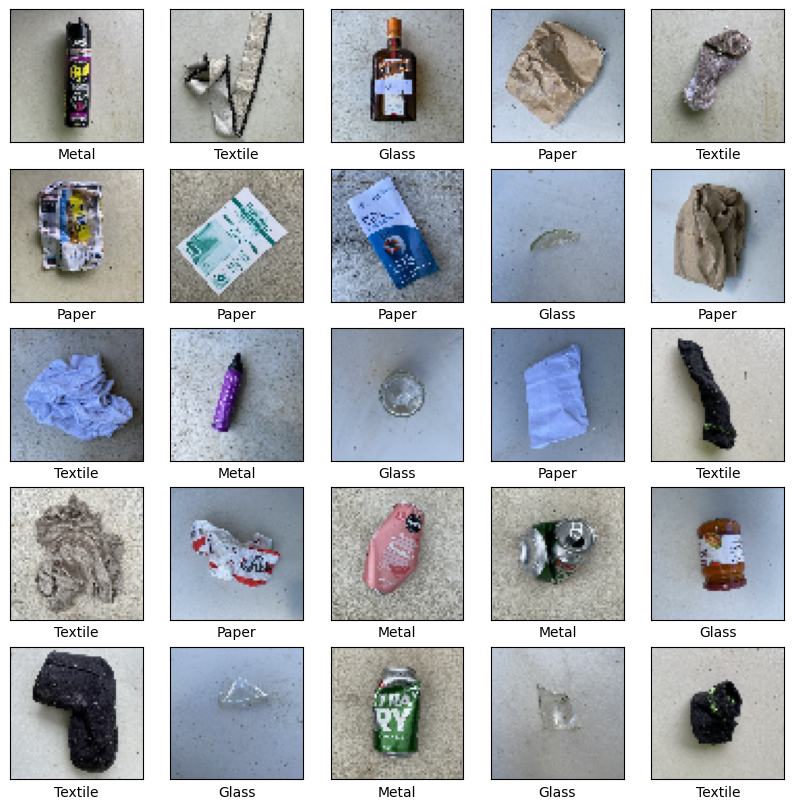

In [11]:
#Display 25 images 
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [12]:
#Sequential Model 1
# Experience 10 with Batch Normalisation
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Input((None,None,3)),
    resize_layer_32,
    
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')     
])

model_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 421,444 (1.61 MB)

 Trainable params: 421,444 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
#Sequential Model 2 
# With Batch Normalisation

model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Input((64,64,3)),
        
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
       
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')   
])

model_2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 298,756 (1.14 MB)

 Trainable params: 298,756 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
#Sequential Model 3 
# Model 3 with batch normalisation

model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Input((64,64,3)),
            
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (5,5), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.1),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')      
])

model_3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 8, 8, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 4, 4, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 235,300 (919.14 KB)

 Trainable params: 235,300 (919.14 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Add callbacks to save the model weight with best accuracy during training
# import ModelCheckpoint package
# from tensorflow.keras.callbacks import ModelCheckpoint
# Source: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

checkpoint_filepath1 = 'C:/Mani/ModelCheckpoint/model1.keras'
model_checkpoint_callback1 = ModelCheckpoint(
    filepath=checkpoint_filepath1,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)


checkpoint_filepath2 = 'C:/Mani/ModelCheckpoint/model2.keras'
model_checkpoint_callback2 = ModelCheckpoint(
    filepath=checkpoint_filepath2,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

checkpoint_filepath3 = 'C:/Mani/ModelCheckpoint/model3.keras'
model_checkpoint_callback3 = ModelCheckpoint(
    filepath=checkpoint_filepath3,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)


In [16]:
model_1.compile(optimizer = tf.keras.optimizers.Adam(0.0015),
                loss = 'sparse_categorical_crossentropy', 
                metrics=['accuracy'])


model_2.compile(optimizer = tf.keras.optimizers.Adam(0.0015),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])


model_3.compile(optimizer = tf.keras.optimizers.Adam(0.0015),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])
               

In [17]:
#Exponential decay for learning rate

def scheduler(epoch, lr):
    if epoch <= 30:
        return lr
    else:
        #return lr * tf.math.exp(-0.01)
        return lr * 0.95
        
    
lr_callback = LearningRateScheduler(scheduler, verbose=1)

In [18]:
# Set number of epochs

epochs = 100
batch_size = 64


In [19]:

# Register the model training start time.
start_time = datetime.now()
print('Time model start:', start_time)


history1 = model_1.fit(train_images, train_labels,
                      batch_size=batch_size, epochs=epochs,
                      validation_split = 0.2, verbose=1,
                      callbacks=[lr_callback, model_checkpoint_callback1])


# Register the model training end time.
end_time = datetime.now()
print('Time model end:', end_time)
print('Model_1_training_time', end_time - start_time)

Time model start: 2024-11-08 15:04:49.230458

Epoch 1: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 1/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2577 - loss: 1.4437
Epoch 1: val_accuracy improved from -inf to 0.23611, saving model to C:/Mani/ModelCheckpoint/model1.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.2599 - loss: 1.4392 - val_accuracy: 0.2361 - val_loss: 1.3743 - learning_rate: 0.0015

Epoch 2: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 2/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3222 - loss: 1.3407
Epoch 2: val_accuracy improved from 0.23611 to 0.26852, saving model to C:/Mani/ModelCheckpoint/model1.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.3254 - loss: 1.3396 - val_accuracy: 0.2685 - val_loss: 1.3439 - learning_rate: 0.0015

Epoch 3: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 3/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7969 - loss: 0.5236 - val_accuracy: 0.6944 - val_loss: 0.7796 - learning_rate: 0.0015

Epoch 19: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 19/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8071 - loss: 0.5449
Epoch 19: val_accuracy did not improve from 0.69444
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8078 - loss: 0.5403 - val_accuracy: 0.6944 - val_loss: 0.7637 - learning_rate: 0.0015

Epoch 20: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 20/100
12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8099 - loss: 0.4872
Epoch 20: val_accuracy improved from 0.69444 to 0.72222, saving model to C:/Mani/ModelCheckpoint/model1.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8094 - loss: 0.4881 - val_accuracy: 0.7222 - val_loss: 0.6997 - learning_rate: 0.0015

Epoch 21: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoc

13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9433 - loss: 0.1859
Epoch 37: val_accuracy did not improve from 0.77778
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9435 - loss: 0.1855 - val_accuracy: 0.7454 - val_loss: 0.7124 - learning_rate: 0.0011

Epoch 38: LearningRateScheduler setting learning rate to 0.0010475058457814156.
Epoch 38/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9490 - loss: 0.1547
Epoch 38: val_accuracy did not improve from 0.77778
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9490 - loss: 0.1542 - val_accuracy: 0.7546 - val_loss: 0.7165 - learning_rate: 0.0010

Epoch 39: LearningRateScheduler setting learning rate to 0.0009951305866707117.
Epoch 39/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9506 - loss: 0.1505
Epoch 39: val_accuracy did not improve from 0.77778
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9507 - loss: 0.1498 - val_accuracy: 0.7500 - val_loss: 0.6987 - learning_rate: 9.9513e-04

Epoch 40:

Epoch 56/100
12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9832 - loss: 0.0699
Epoch 56: val_accuracy did not improve from 0.78241
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9835 - loss: 0.0698 - val_accuracy: 0.7500 - val_loss: 0.8178 - learning_rate: 4.1608e-04

Epoch 57: LearningRateScheduler setting learning rate to 0.00039528009365312754.
Epoch 57/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9733 - loss: 0.0721
Epoch 57: val_accuracy did not improve from 0.78241
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9736 - loss: 0.0722 - val_accuracy: 0.7593 - val_loss: 0.7463 - learning_rate: 3.9528e-04

Epoch 58: LearningRateScheduler setting learning rate to 0.0003755161000299267.
Epoch 58/100
12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9834 - loss: 0.0728
Epoch 58: val_accuracy did not improve from 0.78241
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9825 - loss: 0.0734 - val_accuracy: 0.7500 - val_loss: 0.7405 - learning_rate:

Epoch 75/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9862 - loss: 0.0531
Epoch 75: val_accuracy did not improve from 0.78241
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9864 - loss: 0.0531 - val_accuracy: 0.7500 - val_loss: 0.7914 - learning_rate: 1.5701e-04

Epoch 76: LearningRateScheduler setting learning rate to 0.00014916037034709006.
Epoch 76/100
12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9910 - loss: 0.0489
Epoch 76: val_accuracy did not improve from 0.78241
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9904 - loss: 0.0499 - val_accuracy: 0.7639 - val_loss: 0.7741 - learning_rate: 1.4916e-04

Epoch 77: LearningRateScheduler setting learning rate to 0.00014170235735946334.
Epoch 77/100
12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9881 - loss: 0.0484
Epoch 77: val_accuracy did not improve from 0.78241
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9877 - loss: 0.0489 - val_accuracy: 0.7546 - val_loss: 0.8012 - learning_rate

Epoch 94/100
12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9896 - loss: 0.0496
Epoch 94: val_accuracy did not improve from 0.78241
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9893 - loss: 0.0491 - val_accuracy: 0.7546 - val_loss: 0.7928 - learning_rate: 5.9249e-05

Epoch 95: LearningRateScheduler setting learning rate to 5.628619710478233e-05.
Epoch 95/100
12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9860 - loss: 0.0573
Epoch 95: val_accuracy did not improve from 0.78241
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9864 - loss: 0.0571 - val_accuracy: 0.7546 - val_loss: 0.7984 - learning_rate: 5.6286e-05

Epoch 96: LearningRateScheduler setting learning rate to 5.3471887076739216e-05.
Epoch 96/100
12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9873 - loss: 0.0603
Epoch 96: val_accuracy did not improve from 0.78241
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9870 - loss: 0.0601 - val_accuracy: 0.7454 - val_loss: 0.7858 - learning_rate:

In [20]:
# Register the model training start time.
start_time = datetime.now()
print('Time model start:', start_time)


history2 = model_2.fit(train_images, train_labels,
                       batch_size=batch_size, epochs= epochs, 
                       validation_split = 0.2, verbose=1,
                       callbacks=[lr_callback, model_checkpoint_callback2])

# Register the model training end time.
end_time = datetime.now()
print('Time model end:', end_time)
print('Model_2_training_time', end_time - start_time)

Time model start: 2024-11-08 15:05:39.301674

Epoch 1: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.2315 - loss: 1.4071
Epoch 1: val_accuracy improved from -inf to 0.23148, saving model to C:/Mani/ModelCheckpoint/model2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - accuracy: 0.2332 - loss: 1.4064 - val_accuracy: 0.2315 - val_loss: 1.3803 - learning_rate: 0.0015

Epoch 2: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.3142 - loss: 1.3713
Epoch 2: val_accuracy improved from 0.23148 to 0.31944, saving model to C:/Mani/ModelCheckpoint/model2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.3153 - loss: 1.3706 - val_accuracy: 0.3194 - val_loss: 1.3315 - learning_rate: 0.0015

Epoch 3: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms


Epoch 19: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 19/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8055 - loss: 0.4811
Epoch 19: val_accuracy did not improve from 0.74537
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.8058 - loss: 0.4810 - val_accuracy: 0.7407 - val_loss: 0.7230 - learning_rate: 0.0015

Epoch 20: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 20/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.7934 - loss: 0.4947
Epoch 20: val_accuracy improved from 0.74537 to 0.75000, saving model to C:/Mani/ModelCheckpoint/model2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 0.7939 - loss: 0.4936 - val_accuracy: 0.7500 - val_loss: 0.5908 - learning_rate: 0.0015

Epoch 21: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 21/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.7890 - loss: 0.4875
Epoch 21: val_accuracy improved from 0.75000 to 0.81


Epoch 38: LearningRateScheduler setting learning rate to 0.0010475058457814156.
Epoch 38/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9648 - loss: 0.1152
Epoch 38: val_accuracy did not improve from 0.81944
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9642 - loss: 0.1151 - val_accuracy: 0.8194 - val_loss: 0.4963 - learning_rate: 0.0010

Epoch 39: LearningRateScheduler setting learning rate to 0.0009951305866707117.
Epoch 39/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9503 - loss: 0.1442
Epoch 39: val_accuracy improved from 0.81944 to 0.82407, saving model to C:/Mani/ModelCheckpoint/model2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.9510 - loss: 0.1427 - val_accuracy: 0.8241 - val_loss: 0.4911 - learning_rate: 9.9513e-04

Epoch 40: LearningRateScheduler setting learning rate to 0.0009453740960452705.
Epoch 40/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9758 - loss: 0.0865
Epoch 40: val_accuracy did not improve from 0

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.9784 - loss: 0.0505 - val_accuracy: 0.8333 - val_loss: 0.5385 - learning_rate: 4.1608e-04

Epoch 57: LearningRateScheduler setting learning rate to 0.00039528009365312754.
Epoch 57/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9917 - loss: 0.0339
Epoch 57: val_accuracy did not improve from 0.84722
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.9915 - loss: 0.0343 - val_accuracy: 0.8241 - val_loss: 0.5457 - learning_rate: 3.9528e-04

Epoch 58: LearningRateScheduler setting learning rate to 0.0003755161000299267.
Epoch 58/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9936 - loss: 0.0281
Epoch 58: val_accuracy did not improve from 0.84722
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.9934 - loss: 0.0285 - val_accuracy: 0.8333 - val_loss: 0.5620 - learning_rate: 3.7552e-04

Epoch 59: LearningRateScheduler setting learning rate to 0.00035674029641086236.
Epoch 59/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9899 - loss: 0.0333
Epoch 75: val_accuracy did not improve from 0.85648
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.9902 - loss: 0.0328 - val_accuracy: 0.8241 - val_loss: 0.6384 - learning_rate: 1.5701e-04

Epoch 76: LearningRateScheduler setting learning rate to 0.00014916037034709006.
Epoch 76/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 0.0145
Epoch 76: val_accuracy did not improve from 0.85648
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 1.0000 - loss: 0.0145 - val_accuracy: 0.8194 - val_loss: 0.6226 - learning_rate: 1.4916e-04

Epoch 77: LearningRateScheduler setting learning rate to 0.00014170235735946334.
Epoch 77/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9922 - loss: 0.0232
Epoch 77: val_accuracy did not improve from 0.85648
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.9922 - loss: 0.0231 - val_accuracy: 0.8194 - val_loss: 0.6312 - learning_rate: 1.417

Epoch 94/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9967 - loss: 0.0168
Epoch 94: val_accuracy did not improve from 0.85648
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.9966 - loss: 0.0169 - val_accuracy: 0.8333 - val_loss: 0.6158 - learning_rate: 5.9249e-05

Epoch 95: LearningRateScheduler setting learning rate to 5.628619710478233e-05.
Epoch 95/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9895 - loss: 0.0256
Epoch 95: val_accuracy did not improve from 0.85648
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.9896 - loss: 0.0257 - val_accuracy: 0.8426 - val_loss: 0.6099 - learning_rate: 5.6286e-05

Epoch 96: LearningRateScheduler setting learning rate to 5.3471887076739216e-05.
Epoch 96/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9926 - loss: 0.0252
Epoch 96: val_accuracy did not improve from 0.85648
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.9924 - loss: 0.0252 - val_accuracy: 0.8472 - val_loss: 0.6021 - learning

In [21]:
# Register the model training start time.
start_time = datetime.now()
print('Time model start:', start_time)

history3 = model_3.fit(train_images, train_labels,
                       batch_size=batch_size, epochs= epochs, 
                       validation_split = 0.2, verbose=1,
                       callbacks=[lr_callback, model_checkpoint_callback3])

# Register the model training end time.
end_time = datetime.now()
print('Time model end:', end_time)
print('Model_3_training_time', end_time - start_time )

Time model start: 2024-11-08 15:09:10.697886

Epoch 1: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.2456 - loss: 1.4230
Epoch 1: val_accuracy improved from -inf to 0.26389, saving model to C:/Mani/ModelCheckpoint/model3.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 227ms/step - accuracy: 0.2454 - loss: 1.4217 - val_accuracy: 0.2639 - val_loss: 1.3859 - learning_rate: 0.0015

Epoch 2: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.2379 - loss: 1.3896
Epoch 2: val_accuracy did not improve from 0.26389
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step - accuracy: 0.2394 - loss: 1.3895 - val_accuracy: 0.2593 - val_loss: 1.3849 - learning_rate: 0.0015

Epoch 3: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.2862 - loss: 1.3847
Epoch 3: val_accur

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step - accuracy: 0.7272 - loss: 0.6991 - val_accuracy: 0.7176 - val_loss: 0.7227 - learning_rate: 0.0015

Epoch 19: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 19/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.7506 - loss: 0.6718
Epoch 19: val_accuracy did not improve from 0.71759
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 203ms/step - accuracy: 0.7507 - loss: 0.6710 - val_accuracy: 0.6898 - val_loss: 0.7342 - learning_rate: 0.0015

Epoch 20: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 20/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.7519 - loss: 0.6273
Epoch 20: val_accuracy improved from 0.71759 to 0.72222, saving model to C:/Mani/ModelCheckpoint/model3.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 206ms/step - accuracy: 0.7510 - loss: 0.6299 - val_accuracy: 0.7222 - val_loss: 0.7045 - learning_rate: 0.0015

Epoch 21: LearningRateScheduler setting learning rate to 0.001500000013038516.

Epoch 37/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.8906 - loss: 0.2888
Epoch 37: val_accuracy did not improve from 0.77315
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 199ms/step - accuracy: 0.8914 - loss: 0.2863 - val_accuracy: 0.7639 - val_loss: 0.7340 - learning_rate: 0.0011

Epoch 38: LearningRateScheduler setting learning rate to 0.0010475058457814156.
Epoch 38/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.9114 - loss: 0.2326
Epoch 38: val_accuracy did not improve from 0.77315
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 206ms/step - accuracy: 0.9104 - loss: 0.2346 - val_accuracy: 0.7593 - val_loss: 0.6515 - learning_rate: 0.0010

Epoch 39: LearningRateScheduler setting learning rate to 0.0009951305866707117.
Epoch 39/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.9045 - loss: 0.2268
Epoch 39: val_accuracy did not improve from 0.77315
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step - accuracy: 0.9046 - loss: 0.2264 - val_accuracy: 0.7685 - val_loss: 0.6096 - learning_rate: 9.


Epoch 56: LearningRateScheduler setting learning rate to 0.00041608431201893835.
Epoch 56/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.9767 - loss: 0.0828
Epoch 56: val_accuracy did not improve from 0.80556
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - accuracy: 0.9758 - loss: 0.0837 - val_accuracy: 0.8009 - val_loss: 0.7095 - learning_rate: 4.1608e-04

Epoch 57: LearningRateScheduler setting learning rate to 0.00039528009365312754.
Epoch 57/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9785 - loss: 0.0712
Epoch 57: val_accuracy did not improve from 0.80556
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 209ms/step - accuracy: 0.9780 - loss: 0.0721 - val_accuracy: 0.7917 - val_loss: 0.7378 - learning_rate: 3.9528e-04

Epoch 58: LearningRateScheduler setting learning rate to 0.0003755161000299267.
Epoch 58/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9805 - loss: 0.0592
Epoch 58: val_accuracy did not improve from 0.80556
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - ac


Epoch 75: LearningRateScheduler setting learning rate to 0.00015701091106166132.
Epoch 75/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9843 - loss: 0.0465
Epoch 75: val_accuracy did not improve from 0.80556
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - accuracy: 0.9839 - loss: 0.0470 - val_accuracy: 0.7870 - val_loss: 0.8357 - learning_rate: 1.5701e-04

Epoch 76: LearningRateScheduler setting learning rate to 0.00014916037034709006.
Epoch 76/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9823 - loss: 0.0397
Epoch 76: val_accuracy did not improve from 0.80556
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 0.9819 - loss: 0.0407 - val_accuracy: 0.7778 - val_loss: 0.8227 - learning_rate: 1.4916e-04

Epoch 77: LearningRateScheduler setting learning rate to 0.00014170235735946334.
Epoch 77/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9814 - loss: 0.0583
Epoch 77: val_accuracy did not improve from 0.80556
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - a


Epoch 94: LearningRateScheduler setting learning rate to 5.924862780375406e-05.
Epoch 94/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9844 - loss: 0.0406
Epoch 94: val_accuracy did not improve from 0.81019
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 0.9844 - loss: 0.0405 - val_accuracy: 0.7870 - val_loss: 0.8004 - learning_rate: 5.9249e-05

Epoch 95: LearningRateScheduler setting learning rate to 5.628619710478233e-05.
Epoch 95/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9904 - loss: 0.0335
Epoch 95: val_accuracy did not improve from 0.81019
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.9903 - loss: 0.0337 - val_accuracy: 0.7824 - val_loss: 0.8177 - learning_rate: 5.6286e-05

Epoch 96: LearningRateScheduler setting learning rate to 5.3471887076739216e-05.
Epoch 96/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9821 - loss: 0.0406
Epoch 96: val_accuracy did not improve from 0.81019
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - acc

Text(0.5, 1.0, 'Model 1 Accuracy (Exp:2.4)')

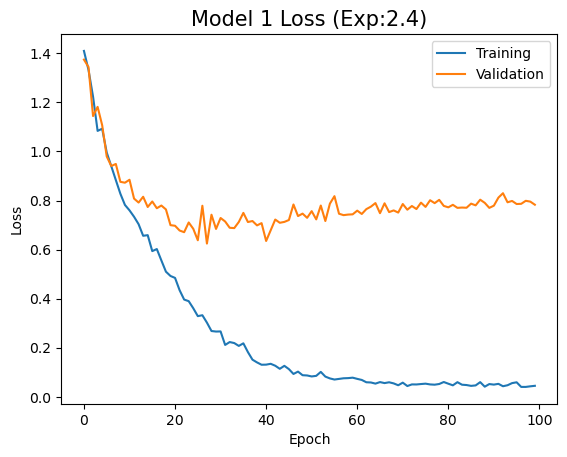

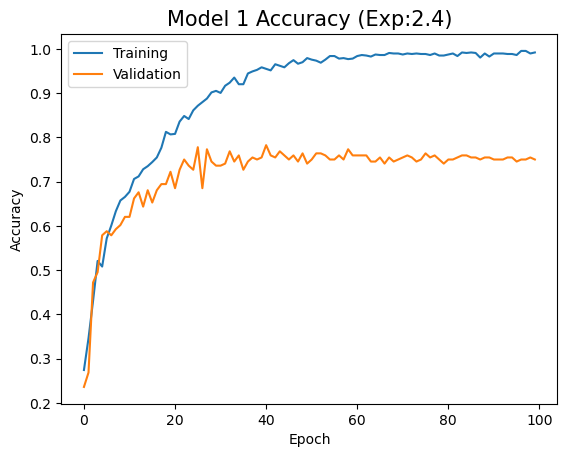

In [22]:

#Plot the training and validation loss
plt.figure()
plt.plot(history1.history['loss'], label='Training')
plt.plot(history1.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 1 Loss (Exp:2.4)', fontsize = 15)

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history1.history['accuracy'], label='Training')
plt.plot(history1.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 1 Accuracy (Exp:2.4)', fontsize = 15)


Text(0.5, 1.0, 'Model 2 Accuracy (Exp:2.4)')

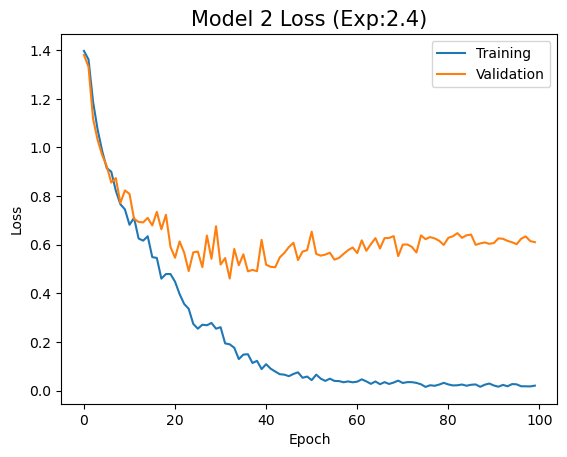

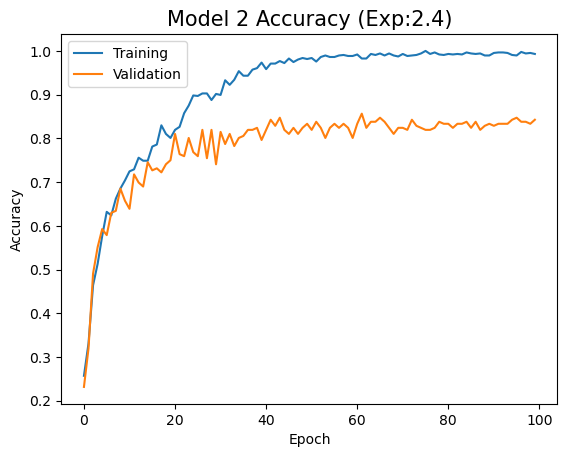

In [23]:
#Plot the training and validation loss
plt.figure()
plt.plot(history2.history['loss'], label='Training')
plt.plot(history2.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 2 Loss (Exp:2.4)', fontsize = 15)

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history2.history['accuracy'], label='Training')
plt.plot(history2.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 2 Accuracy (Exp:2.4)', fontsize = 15)

Text(0.5, 1.0, 'Model 3 Accuracy (Exp:2.4)')

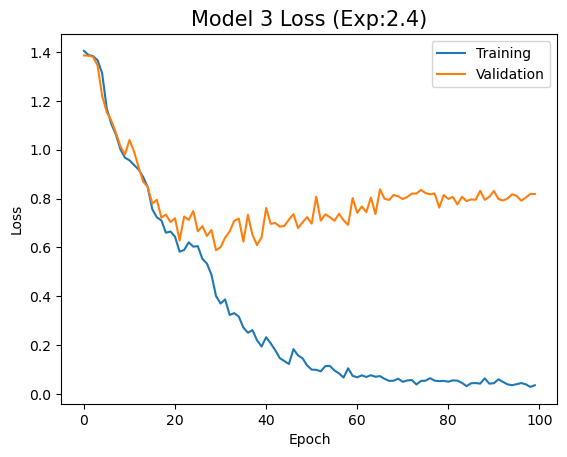

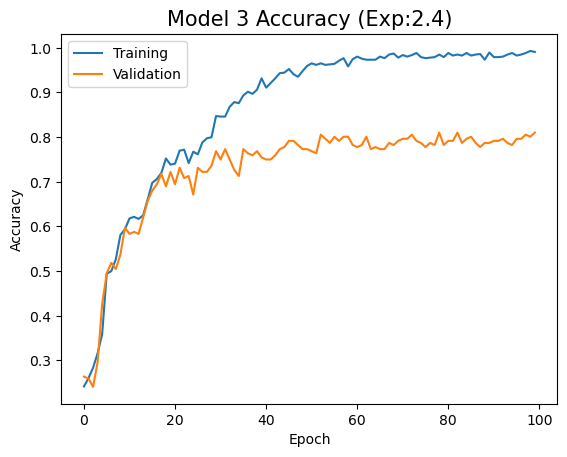

In [24]:
#Plot the training and validation loss
plt.figure()
plt.plot(history3.history['loss'], label='Training')
plt.plot(history3.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 3 Loss (Exp:2.4)', fontsize = 15)

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history3.history['accuracy'], label='Training')
plt.plot(history3.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 3 Accuracy (Exp:2.4)', fontsize = 15)

In [25]:
# Evaluate the test result for model 1, 2, 3
model_1.load_weights(checkpoint_filepath1)
Test_result1 = model_1.evaluate(test_images, test_labels, batch_size = 64)

model_2.load_weights(checkpoint_filepath2)
Test_result2 = model_2.evaluate(test_images, test_labels, batch_size = 64)

model_3.load_weights(checkpoint_filepath3)
Test_result3 = model_3.evaluate(test_images, test_labels, batch_size = 64)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7728 - loss: 0.6766 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7659 - loss: 0.7969
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7947 - loss: 0.7245


In [26]:
predictions1 = model_1.predict(test_images)     # Vector of probabilities
pred_label1 = np.argmax(predictions1, axis = 1) # We take the highest probability

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [27]:
predictions2 = model_2.predict(test_images)     # Vector of probabilities
pred_label2 = np.argmax(predictions2, axis = 1) # We take the highest probability

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [28]:
predictions3 = model_3.predict(test_images)     # Vector of probabilities
pred_label3 = np.argmax(predictions3, axis = 1) # Take to position where the probability is highest

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


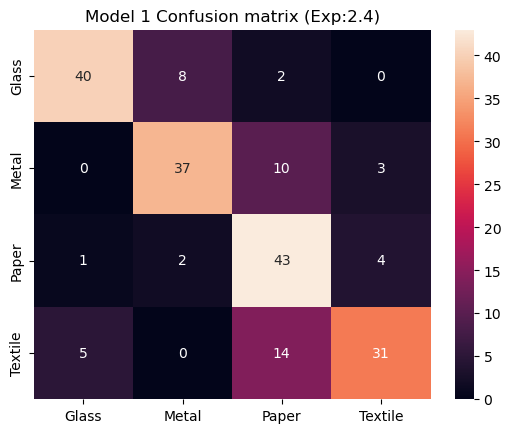

In [29]:
CM1 = confusion_matrix(test_labels, pred_label1)
ax = plt.axes()
sn.heatmap(CM1, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Model 1 Confusion matrix (Exp:2.4)')
plt.show()

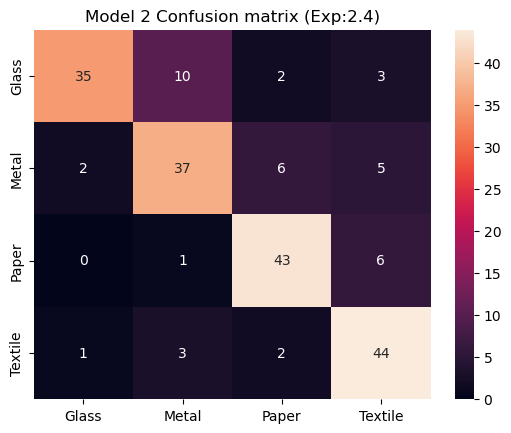

In [30]:
CM2 = confusion_matrix(test_labels, pred_label2)
ax = plt.axes()
sn.heatmap(CM2, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Model 2 Confusion matrix (Exp:2.4)')
plt.show()




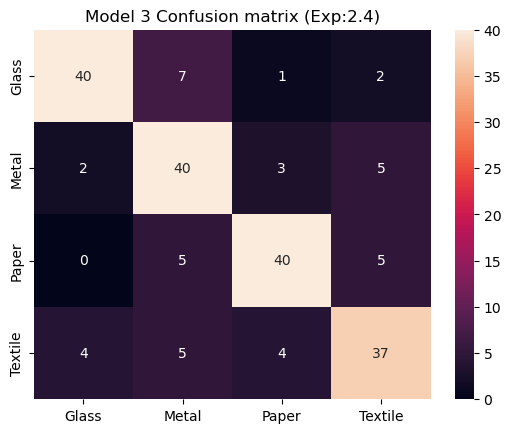

In [31]:
CM3 = confusion_matrix(test_labels, pred_label3)
ax = plt.axes()
sn.heatmap(CM3, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Model 3 Confusion matrix (Exp:2.4)')
plt.show()